In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

train_df = pd.read_csv("../input/titanic/train.csv")
test_df = pd.read_csv("../input/titanic/test.csv")
submission = pd.read_csv("../input/titanic/gender_submission.csv")

pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train_df.head()
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [3]:
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train_df["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [6]:
train_df["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [7]:
train_df["Cabin"].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [8]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
# test_df.describe()

# test_df.isnull().sum()

train_df[["Embarked","Survived","PassengerId"]].dropna()

embarked_df = train_df[["Embarked","Survived","PassengerId"]].dropna().groupby(["Embarked","Survived"]).count().unstack()
# embarked_df.plot.bar(stacked=True)

embarked_df["survived_rate"]=embarked_df.iloc[:,0]/(embarked_df.iloc[:,0] + embarked_df.iloc[:,1])
#embarked_df

# p.099
sex_df = train_df[["Sex", "Survived", "PassengerId"]].dropna().groupby(["Sex", "Survived"]).count().unstack()
#sex_df.plot.bar(stacked=True)

# p.100
ticket_df = train_df[["Pclass","Survived","PassengerId"]].dropna().groupby(["Pclass","Survived"]).count().unstack()
# ticket_df.plot.bar(stacked=True)

# p.101
# これがどうもValueErrorになってしまう
#plt.hist((train_df[train_df["Survived"] == 0][["Age"]].values, train_df[train_df["Survived"] == 1][["Age"]].values), 
#         histtype="barstacked", bins=8, label=("Death", "Survive"))
#plt.legend()

train_df_corr = pd.get_dummies(train_df, columns=["Sex"], drop_first=True)
train_df_corr = pd.get_dummies(train_df_corr, columns=["Embarked"])

# p.104-p.104
train_corr = train_df_corr.corr()
# train_corr
#plt.figure(figsize=(9,9))
#sns.heatmap(train_corr, vmax=1, vmin=-1, center=0, annot=True)

# p.106
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)

# p.107
# all_df.isnull().sum()

# p.108
Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
Fare_mean.columns = ["Pclass", "Fare_mean"]

# p.109
all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")
all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]
all_df = all_df.drop("Fare_mean", axis=1)

# p.111
name_df = all_df["Name"].str.split("[,.]",2,expand=True)
name_df.columns = ["family_name", "honorific", "name"]
name_df["family_name"] = name_df["family_name"].str.strip()
name_df["honorific"] = name_df["honorific"].str.strip()
name_df["name"] = name_df["name"].str.strip()

# p.112 各名称ごとの人数をカウントする
name_df["honorific"].value_counts()

# p.113 敬称ごとの年齢分布を確認する
all_df = pd.concat([all_df, name_df], axis=1)

# p.115 敬称ごとの年齢の分布を確認
#plt.figure(figsize=(18, 5))
#sns.boxplot(x="honorific", y="Age", data=all_df)

# 敬称ごとの年齢の平均値を確認する
#all_df[["Age", "honorific"]].groupby("honorific").mean()

# p.116 敬称ごとの生存率の違いについて確認する
train_df = pd.concat([train_df, name_df[0:len(train_df)].reset_index(drop=True)], axis=1)
test_df = pd.concat([test_df, name_df[len(train_df):].reset_index(drop=True)], axis=1)
honorific_df = train_df[["honorific", "Survived", "PassengerId"]].dropna().groupby(["honorific", "Survived"]).count().unstack()
#honorific_df.plot.bar(stacked=True)

# p.118 年齢が欠損しているものは、敬称ごとの平均年齢で補完する
honorific_age_mean = all_df[["honorific", "Age"]].groupby("honorific").mean().reset_index()
honorific_age_mean.columns = ["honorific", "honorific_Age"]
all_df = pd.merge(all_df, honorific_age_mean, on="honorific", how="left")
all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_Age"]
all_df = all_df.drop(["honorific_Age"], axis=1)

# 家族人数を追加する
all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]
#all_df["family_num"].value_counts()

# p.119 同船している家族人数が0人（1人乗船）かどうかを表すaloneという変数を追加する
all_df.loc[all_df["family_num"]==0, "alone"] = 1
all_df["alone"].fillna(0, inplace=True)

# 不要な変数を削除する
all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)

# p.120 カテゴリ変数を数値に変換する
categories = all_df.columns[all_df.dtypes == "object"]
# print(categories)

# 敬称はMr, Miss, Mrs, Master以外は数が少ないため、otherとして統合する
all_df.loc[~((all_df["honorific"]=="Mr") | (all_df["honorific"]=="Miss") | (all_df["honorific"]=="Mrs") | (all_df["honorific"]=="Master")), "honorific"] = "other"
# all_df.honorific.value_counts()

# p.121 文字列を数値に変換する:Label Encoding
from sklearn.preprocessing import LabelEncoder
all_df["Embarked"].fillna("missing", inplace=True)

le = LabelEncoder()
le = le.fit(all_df["Sex"])
all_df["Sex"] = le.transform(all_df["Sex"])

# p.123 categories内のすべての列をLabel Encodingする
for cat in categories:
    le = LabelEncoder()
    #print(cat)
    if all_df[cat].dtypes == "object":
        le = le.fit(all_df[cat])
        all_df[cat] = le.transform(all_df[cat])
all_df.head()

# p.124 すべてのデータを学習データとテストデータに戻す
train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
train_Y = train_df["Survived"]

test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)

# p.125 モデリングを行う
import lightgbm as lgb

# p. 131 ホールドアウト、クロスバリデーションを行うためのライブラリをインポートする
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# 学習データの20%を検証データに分割する
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.2)

# LightGBM用のデータセットを作成する
categories = ["Embarked", "Pclass", "Sex", "honorific", "alone"]
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categories)
lgb_eval = lgb.Dataset(X_valid, y_valid, categorical_feature=categories, reference=lgb_train)

# p.132 ハイパーパラメータを設定する
lgbm_params = {
    "objective":"binary", # 2値分類
    "random_seed":1234
}

# LightGBMによる機械学習モデルを学習させる
# 注：early_stopping_rounds, verbose_eval は deprecated とのこと。
model_lgb = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval, num_boost_round=100, early_stopping_rounds=20, verbose_eval=10)

# p.133 各変数の重要度を調べる
#model_lgb.feature_importance()
importance = pd.DataFrame(model_lgb.feature_importance(), index=X_train.columns, columns=["importance"]).sort_values(by="importance", ascending=True)
#importance.plot.barh()

# p.135 モデルを検証データに適用する
y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)

# p.136 accuracyを計算するライブラリをインポート
from sklearn.metrics import accuracy_score
#accuracy_score(y_valid, np.round(y_pred))

# ハイパーパラメータを変更する
lgbm_params = {
    "objective":"binary",
    "max_bin":331,
    "num_leaves": 20,
    "min_data_in_leaf": 57,
    "random_seed": 1234
}

lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categories)
lgb_eval = lgb.Dataset(X_valid, y_valid, categorical_feature=categories, reference=lgb_train)
model_lgb = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval, num_boost_round=100, early_stopping_rounds=20, verbose_eval=10)

y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
accuracy_score(y_valid, np.round(y_pred))

# p.138 クロスバリデーションによる学習
folds = 3
kf = KFold(n_splits=folds)
models = []
for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categories)
    lgb_eval = lgb.Dataset(X_valid, y_valid, categorical_feature=categories, reference=lgb_train)
    model_lgb = lgb.train(lgbm_params, lgb_train, valid_sets=lgb_eval, num_boost_round=100, early_stopping_rounds=20, verbose_eval=10)
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    print(accuracy_score(y_valid, np.round(y_pred)))
    models.append(model_lgb)
    
# p.141 テストデータにおける予測結果を算出する
preds = []

for model in models:
    pred = model.predict(test_X)
    preds.append(pred)
    
preds_array = np.array(preds)
preds_mean = np.mean(preds_array, axis=0)
preds_int = (preds_mean > 0.5).astype(int)
submission["Survived"] = preds_int
submission

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.


[LightGBM] [Info] Number of positive: 263, number of negative: 449
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 220
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.369382 -> initscore=-0.534869
[LightGBM] [Info] Start training from score -0.534869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


<AxesSubplot:xlabel='Pclass2'>

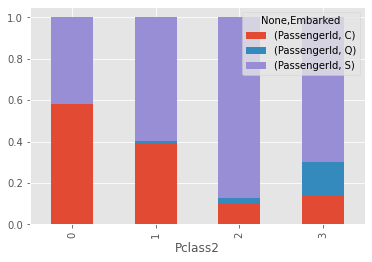

In [10]:
# p.149 チケットクラスごとの人数を確認する
train_df = pd.read_csv("../input/titanic/train.csv")
test_df = pd.read_csv("../input/titanic/test.csv")
all_df = pd.concat([train_df, test_df], sort=False).reset_index(drop=True)
#all_df.Pclass.value_counts()
#all_df.Pclass.value_counts().plot.bar()

# p.150 料金の分布を確認する
#all_df[["Pclass", "Fare"]].groupby("Pclass").describe()

#plt.figure(figsize=(6, 5))
#sns.boxplot(x="Pclass", y="Fare", data=all_df)

# p.152 1等級チケットのうち、高額チケット(1等級チケットの上位25%）をPClass0にする
# Pclass2のうちFareが108より大きいものを0に変更する
all_df["Pclass2"] = all_df["Pclass"]
all_df.loc[all_df["Fare"]>108, "Pclass2"] = 0
#all_df[all_df["Pclass2"] == 0]

# p.153 チケットクラスごとの年齢の分布を確認する
all_df[["Pclass2", "Age"]].groupby("Pclass2").describe()
#plt.figure(figsize=(6, 5))
#sns.boxplot(x="Pclass2", y="Age", data=all_df)

# 15歳より上の人に限定して再度確認する
all_df[all_df["Age"]>15][["Pclass2","Age"]].groupby("Pclass2").describe()
#plt.figure(figsize=(6, 5))
#sns.boxplot(x="Pclass2", y="Age", data=all_df[all_df["Age"]>15])

#all_df.plot.scatter(x="Age", y="Fare", alpha=0.5)

# p.156 チケットクラスごとの乗船家族人数を確認する
all_df["family_num"] = all_df["SibSp"] + all_df["Parch"]
#all_df[["Pclass2", "family_num"]].groupby("Pclass2").describe()

#plt.figure(figsize=(6, 5))
#sns.boxplot(x="Pclass2", y="family_num", data=all_df)

# p.158 チケットクラスごとの男女比について確認する
Pclass_gender_df = all_df[["Pclass2", "Sex", "PassengerId"]].dropna().groupby(["Pclass2", "Sex"]).count().unstack()
#Pclass_gender_df.plot.bar(stacked=True)

Pclass_gender_df["male_ratio"] = Pclass_gender_df["PassengerId", "male"]/(Pclass_gender_df["PassengerId", "male"] + Pclass_gender_df["PassengerId", "female"])
#Pclass_gender_df

# p.159 港ごとの違いを確認
Pclass_emb_df = all_df[["Pclass2","Embarked","PassengerId"]].dropna().groupby(["Pclass2", "Embarked"]).count().unstack()
Pclass_emb_df = Pclass_emb_df.fillna(0)
#Pclass_emb_df.plot.bar(stacked=True)
Pclass_emb_df_ratio = Pclass_emb_df.copy()
Pclass_emb_df_ratio["sum"] = Pclass_emb_df_ratio["PassengerId", "C"] + Pclass_emb_df_ratio["PassengerId", "Q"] + Pclass_emb_df_ratio["PassengerId", "S"]
Pclass_emb_df_ratio["PassengerId", "C"] = Pclass_emb_df_ratio["PassengerId", "C"] / Pclass_emb_df_ratio["sum"]
Pclass_emb_df_ratio["PassengerId", "Q"] = Pclass_emb_df_ratio["PassengerId", "Q"] / Pclass_emb_df_ratio["sum"]
Pclass_emb_df_ratio["PassengerId", "S"] = Pclass_emb_df_ratio["PassengerId", "S"] / Pclass_emb_df_ratio["sum"]
Pclass_emb_df_ratio = Pclass_emb_df_ratio.drop(["sum"],axis=1)
Pclass_emb_df_ratio
Pclass_emb_df_ratio.plot.bar(stacked=True)